In [19]:
#combine all variables on one figure

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
import skbio
from collections import Counter
from statsmodels.formula.api import ols
import researchpy as rp

In [2]:
promoterpref='EPD_TSS_outward_promoter5UTR'
file_names='non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
window_bed = f'../../../data/output/{file_names}/rolling_window/{promoterpref}_windows.bed'
promoter_bed = f'../../../data/output/{file_names}/FIMO/EPD_promoters.bed'#to extract the Eukaryotic promoter database TSSs
promoter_5UTR_bed = f'../../../data/output/{file_names}/FIMO/promoters_5UTR.bed'
foldername_prefix = 'all_combined_rw'

In [3]:
GC_content_tsv = f'../../../data/output/{file_names}/rolling_window/GC_content_rw_{promoterpref}/{promoterpref}_GCcontent_rw.tsv'

In [4]:
TF_diversity_bed = f'../../../data/output/{file_names}/rolling_window/TF_diversity_rw_{promoterpref}/{promoterpref}_TF_diversity.bed'

In [5]:
bp_covered = f'../../../data/output/{file_names}/rolling_window/TFBS_coverage_rw_{promoterpref}/{promoterpref}_bpcovered_rw.bed'


In [6]:
#bp covered chromatin files
root_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw_{promoterpref}/{promoterpref}_root_bpcovered_rw.bed'
shoot_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw_{promoterpref}/{promoterpref}_shoot_bpcovered_rw.bed'
rootshootintersect_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw_{promoterpref}/{promoterpref}_rootshootintersect_bpcovered_rw.bed'

In [7]:
#make directory for the plots to be exported to
dirName = f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}_{promoterpref}/'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/rolling_window/all_combined_rw_EPD_TSS_outward_promoter5UTR/  already exists


In [8]:
#make directory for the plots to be exported to
dirName = f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}_{promoterpref}/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/rolling_window/all_combined_rw_EPD_TSS_outward_promoter5UTR/plots  already exists


In [9]:
#sort GC content input files
promoters = pd.read_csv(Czechowski_gene_categories, sep='\t', header=None)
cols = ['AGI','gene_type']
promoters.columns = cols
GC_content = pd.read_table(GC_content_tsv, sep='\t', header=None)
cols2 = ['name', 'percentage_GC_content']
GC_content.columns = cols2
#Make AGI column
GC_content['AGI'] = GC_content.name.str.split('_',expand=True)[0]
#make window number column
GC_content = GC_content.assign(window_number=GC_content.name.str.extract(r'_(.*?)\:'))
#make chr column
GC_content = GC_content.assign(chr=GC_content.name.str.split(':',n=3,expand=True)[2])
#make start column
GC_content = GC_content.assign(start=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[0])
#make stop column
GC_content = GC_content.assign(stop=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[1])
#make df columns integars
GC_content = GC_content.astype({'stop':'int','start':'int','chr':'int'})
#add window length column
GC_content = GC_content.assign(window_length=GC_content.stop - GC_content.start)
#drop name column
GC_content.drop(['name'], axis=1, inplace=True)

# #merge to limit to genes of interest
# GC_content = pd.merge(promoters, GC_content, how ='left', on='AGI')
# GC_content

In [10]:
#Read in TF_diversity_bed
TF_diversity = pd.read_table(TF_diversity_bed, sep='\t', header=0)
#Read in windows_bed
windows_df = pd.read_table(window_bed, sep='\t', header=None)
cols = ['chr', 'start', 'stop', 'name']
windows_df.columns = cols
#merge windows bed with TF_diversity
TF_diversity = pd.merge(windows_df,TF_diversity, how='left', on='name')
#turn NaN into 0s
TF_diversity[["Shannon_diversity_TF",'Shannon_diversity_TF_family', 'unique_TF_count', 'total_TF_count','TF_family_count']] = TF_diversity[["Shannon_diversity_TF",'Shannon_diversity_TF_family', 'unique_TF_count', 'total_TF_count','TF_family_count']].fillna(0)
#Make AGI column
TF_diversity['AGI'] = TF_diversity.name.str.split('_',expand=True)[0]
#make window number column
TF_diversity['window_number'] = TF_diversity.name.str.split('_',expand=True)[1]
#make df columns integars
TF_diversity = TF_diversity.astype({'stop':'int','start':'int','chr':'int','Shannon_diversity_TF':'int','Shannon_diversity_TF_family':'int', 'unique_TF_count':'int', 'total_TF_count':'int','TF_family_count':'int'})
#add window length column
TF_diversity = TF_diversity.assign(window_length=TF_diversity.stop - TF_diversity.start)
#drop name column
TF_diversity.drop(['name'], axis=1,inplace=True)

In [11]:
#read in coverage bedfile
coverage_df = pd.read_table(bp_covered, sep='\t', header=None)
col = ['chr','start','stop','name','no._of_overlaps', 'no._of_bases_covered','window_length','fraction_bases_covered']
coverage_df.columns = col
#add % bases covered column
coverage_df['percentage_bases_covered'] = coverage_df.fraction_bases_covered * 100
#Add AGI and window_number column to coverage_df
coverage_df = coverage_df.assign(AGI=coverage_df.name.str.extract(r'(.*?)\_'))
coverage_df['window_number'] = coverage_df.name.str.split('_', n=2, expand = True)[1]
#coverage_df = coverage_df.assign(window_number=coverage_df.name.str[-1:])
#drop name column
coverage_df.drop(['name'], axis=1,inplace=True)

In [12]:
## merge all of the dfs on AGI, window number, chr, start and stop
# merge GC content with TF diversity df
all_combined = pd.merge(GC_content, TF_diversity, on = ['chr','start','stop','AGI','window_number','window_length'])
# merge this with TFBS coverage df
all_combined = pd.merge(all_combined, coverage_df, on = ['chr','start','stop','AGI','window_number','window_length'])
#drop fraction_bases_covered and no._of_bases_covered
all_combined.drop(['no._of_bases_covered', 'fraction_bases_covered'], axis=1, inplace = True)

In [13]:
all_combined

,percentage_GC_content,AGI,window_number,chr,start,stop,window_length,Shannon_diversity_TF,Shannon_diversity_TF_family,unique_TF_count,total_TF_count,TF_family_count,no._of_overlaps,percentage_bases_covered
0,38.0,AT1G01010,-19,1,2630,2730,100,0,0,0,0,0,0,0.0
1,37.0,AT1G01010,-18,1,2680,2780,100,0,0,0,0,0,0,0.0
2,34.0,AT1G01010,-17,1,2730,2830,100,0,0,0,0,0,0,0.0
3,37.0,AT1G01010,-16,1,2780,2880,100,0,0,0,0,0,0,0.0
4,39.0,AT1G01010,-15,1,2830,2930,100,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260038,39.0,AT5G67620,-16,5,26966745,26966845,100,0,0,1,1,1,1,21.0
260039,33.0,AT5G67620,-17,5,26966795,26966895,100,0,0,0,0,0,0,0.0
260040,34.0,AT5G67620,-18,5,26966845,26966945,100,0,0,0,0,0,0,0.0
260041,34.0,AT5G67620,-19,5,26966895,26966995,100,0,0,0,0,0,0,0.0


In [14]:
#allow colour codes in seaborn
sns.set(color_codes=True)
sns.set_style("white")

In [15]:
#remove windows with fewer than 100 promoters extending to that location
all_combined = all_combined[all_combined['window_number'].map(all_combined['window_number'].value_counts()) > 99]

In [16]:
def add_coverage(df,coverage_bed,suffix):
    """add % bp covered data from a bed file to the df. Prefix is a name added to any new columns"""
    #read in bed file
    coverage_df = pd.read_table(coverage_bed, sep='\t', header=None)
    cols = ['chr','start','stop','name','no._of_overlaps', 'no._of_bases_covered','window_length','fraction_bases_covered']
    coverage_df.columns = cols
    #add % bases covered column
    coverage_df['percentage_bases_covered'] = coverage_df['fraction_bases_covered'] * 100
    #filter columns
    coverage_df = coverage_df[['chr','start','stop','name','percentage_bases_covered']]
    #make df columns integars
    df = df.astype({'stop':'int','start':'int','chr':'int'})
    coverage_df = coverage_df.astype({'stop':'int','start':'int','chr':'int'})
    #merge the dfs
    merged = pd.merge(df,coverage_df, how='left',on=['chr','start','stop'],suffixes=('', f'_{suffix}'))
    #remove NaN
    #merged = merged[merged['name'].notnull()] 
    return merged

In [17]:
def rep_sample(df, col, n, random_state):
    """function to return a df with equal sample sizes
    taken from here: https://stackoverflow.com/questions/39457762/python-pandas-conditionally-select-a-uniform-sample-from-a-dataframe"""
    #identify number of categories
    nu = df[col].nunique()
    # find number of rows
    m = len(df)
    # integar divide total sample size by number of categories
    mpb = n // nu
    # multiply this by the number of categories and subtract from the number of samples to find the remainder
    mku = n - mpb * nu
    # make an array fileld with zeros corresponding to each category
    fills = np.zeros(nu)

    # make values in the array 1s up until the remainder
    fills[:mku] = 1

    # calculate sample sizes for each category
    sample_sizes = (np.ones(nu) * mpb + fills).astype(int)

    #group the df by categories
    gb = df.groupby(col)
    #define sample size function
    sample = lambda sub_df, i: sub_df.sample(sample_sizes[i], random_state = random_state)
    #run sample size function on each category
    subs = [sample(sub_df, i) for i, (_, sub_df) in enumerate(gb)]
    #return concatenated sub dfs
    return pd.concat(subs)

In [18]:
def windows_coords(output_prefix,all_combined_df,
                   variable_of_interest1,variable_of_interest1_name,
                   variable_of_interest2,variable_of_interest2_name,
                   variable_of_interest3,variable_of_interest3_name,promoter_bed,promoter_5UTR_bed,
                   window_offset,chromatin_tissue_variable='percentage_bases_covered_rootshootintersect_chrom',
                   chromatin_tissue_variable_name='% open chromatin root and shoot intersect',x_range=False,estimator='median',ci=95, n_boot=10000, 
                   genetype=False, genetype2=False, genetype3=False):
    """function to add the centre of each window corresponding to each window no. and return a lineplot. Also add promoter length distributio, Araport TSS distribution,
    EPD TSS distribution (add the most common TSS as documented on eukaryotic promoter database Arabidopsis last modified on EPD 06/06/2018)"""
    #read in bed file
    promoter_df = pd.read_table(promoter_bed, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes']
    promoter_df.columns = col
    promoter_5UTR_df = pd.read_table(promoter_5UTR_bed, sep='\t', header=None)
    promoter_5UTR_df.columns = col
    #add promoter length column
    promoter_df['promoter_length'] = promoter_df.stop-promoter_df.start
    #temporarily merge promoter_df with promoter_5UTR_bed
    temp_merged = pd.merge(promoter_df,promoter_5UTR_df,how='left',on='AGI', suffixes = ('','_promsUTR'))
    #add 5UTR length column
    temp_merged['five_UTR_length'] = (temp_merged.stop_promsUTR-temp_merged.start_promsUTR) - temp_merged.promoter_length
    #filter columns
    temp_merged = temp_merged[['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes','promoter_length','five_UTR_length']]
    #rename temp_merged back to promoter_df
    promoter_df = temp_merged.copy()
    #merge promoter_df with all_combined_df on AGI
    merged = pd.merge(all_combined_df, promoter_df, on='AGI',  how='left',suffixes=('','_wholeprom'))
    
    #remove NaN for all variables of interest
    merged = merged[merged[variable_of_interest1].notnull()]
    merged = merged[merged[variable_of_interest2].notnull()]
    merged = merged[merged[variable_of_interest3].notnull()]
    #make columns integars
    merged = merged.astype({'stop_wholeprom':'int','start_wholeprom':'int','start':'int','stop':'int'})
    #split merged into 2 dfs by strand
    pos = merged[merged.strand == '+'].copy()
    neg = merged[merged.strand == '-'].copy()
    
    #add variable of interest position column where position is the middle of the window using the Araport TSS (end of promoter bed file) as a reference
    #this will lead to positive positions being in the 5'UTR and negative in the promoter region
    
    pos['position'] = (pos.stop_wholeprom) - (pos.start+0.5*(pos.stop-pos.start))
    neg['position'] = (neg.start+0.5*(neg.stop-neg.start)) - neg.start_wholeprom
    merged2 = pd.merge(pos,neg,how='outer')

    merged2 = merged2.astype({'position': 'int64'})
    #make window number an integar
    all_combined_df = all_combined_df.astype({'window_number': 'float'})
    
    #calculate promoter and 5UTR window length based on window cutoff
    number_of_windows = len(all_combined_df.window_number.unique())
    #promoter window number plus 1 because window 0 is excluded
    promoter_window_number = len(all_combined_df[all_combined_df.window_number < 0].window_number.unique()) + 1
    #5UTR window number plus 1
    five_UTR_window_number = len(all_combined_df[all_combined_df.window_number > 0].window_number.unique()) + 1
    

    #max_promoter_length
    window_length = all_combined_df.window_length.max()
    max_promoter_length = promoter_window_number*(window_length-window_offset)
    max_5UTR_length = five_UTR_window_number*(window_length-window_offset)

    #make integars
    merged2 = merged2.astype({f'{variable_of_interest1}':'float64',
                              f'{variable_of_interest2}':'float64',
                              f'{variable_of_interest3}':'float64',
                              f'{chromatin_tissue_variable}':'float64'})


    #change estimator
    if estimator == 'mean':
        new_estimator=estimator
        
    if estimator == 'median':
        new_estimator = np.median
    #set number of subplots so can easily change all output possibilities, where subplotA is the top
    subplots = 4

    f, axes = plt.subplots(subplots, figsize=(10,10))
    OpenChromplot = axes[subplots-subplots]
    variableofinterest1plot = axes[subplots-(subplots-1)]
    variableofinterest2plot = axes[subplots-(subplots-2)]
    variableofinterest3plot = axes[subplots-(subplots-3)]

   
    
    #check the plot axes variables are there. If they are not, assign None to them
    try:
        OpenChromplot
    except NameError:
        OpenChromplot = None

    try:
        variableofinterest1plot
    except NameError:
        variableofinterest1plot = None
    try:
        variableofinterest2plot
    except NameError:
        variableofinterest2plot = None
        
    try:
        variableofinterest3plot
    except NameError:
        variableofinterest3plot = None
    
    #first plot letter name
    nextletter = 'A'
    
    if genetype!=False:

        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #make integars
        merged2 = merged2.astype({'window_number':'float64'})
        #remove windows with fewer than 50 promoters extending to that location if looking at specific genetypes
        merged2 = merged2[merged2['window_number'].map(merged2['window_number'].value_counts()) > 49]
        #calculate promoter and 5UTR window length based on window cutoff
        number_of_windows = len(merged2.window_number.unique())
        #promoter window number plus 1 because window 0 is excluded
        promoter_window_number = len(merged2[merged2.window_number < 0].window_number.unique()) + 1
        #5UTR window number plus 1
        five_UTR_window_number = len(merged2[merged2.window_number > 0].window_number.unique()) + 1
        
        
        #redefine max_promoter_length
        window_length = merged2.window_length.max()
        max_promoter_length = promoter_window_number*(window_length-window_offset)
        max_5UTR_length = five_UTR_window_number*(window_length-window_offset)
        
    #make all values of interest negative as upstream from ATG
    merged_positive = merged2.copy()
    merged2[['promoter_length','position']] = -merged2[['promoter_length','position']]

    if genetype==False:
        

        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:
            #Open chromatin lineplot
            sns.lineplot(y=merged2[chromatin_tissue_variable],x=merged2.position,ax=OpenChromplot,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles and axes labels
            OpenChromplot.set_title(f'{nextletter}: All promoters {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')
            OpenChromplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)

        
        #if variableofinterest1plot variable present, add that plot
        if variableofinterest1plot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[variable_of_interest1], x=merged2.position, ax=variableofinterest1plot,estimator=new_estimator,
                         ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterest1plot.set_title(f'{nextletter}: All promoters sliding windows {variable_of_interest1_name}', weight='bold')
            variableofinterest1plot.set_ylabel(f'{estimator} {variable_of_interest1_name}')
            variableofinterest1plot.set_xlabel('')
            variableofinterest1plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)
            
        #if variableofinterest2plot variable present, add that plot
        if variableofinterest2plot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[variable_of_interest2], x=merged2.position, ax=variableofinterest2plot,estimator=new_estimator,
                         ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterest2plot.set_title(f'{nextletter}: All promoters sliding windows {variable_of_interest2_name}', weight='bold')
            variableofinterest2plot.set_ylabel(f'{estimator} {variable_of_interest2_name}')
            variableofinterest2plot.set_xlabel('')
            variableofinterest2plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)

        #if variableofinterest3plot variable present, add that plot
        if variableofinterest3plot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[variable_of_interest3], x=merged2.position, ax=variableofinterest3plot,estimator=new_estimator,
                         ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterest3plot.set_title(f'{nextletter}: All promoters sliding windows {variable_of_interest3_name}', weight='bold')
            variableofinterest3plot.set_ylabel(f'{estimator} {variable_of_interest3_name}')
            variableofinterest3plot.set_xlabel('position relative to Araport 11 TSS')
            


               
    elif genetype2==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:        
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                         ax=OpenChromplot,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles and axes labels
            OpenChromplot.set_title(f'{nextletter}: {genetype} {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')
            OpenChromplot.set_xticklabels([]) 
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)


        #if variableofinterest1plot variable present, add that plot
        if variableofinterest1plot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest1], x=merged2[merged2.gene_type == genetype].position,
                         ax=variableofinterest1plot, estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterest1plot.set_title(f'{nextletter}: {genetype} {variable_of_interest1_name}', weight='bold')
            variableofinterest1plot.set_ylabel(f'{estimator} {variable_of_interest1_name}')
            variableofinterest1plot.set_xlabel('')
            variableofinterest1plot.set_xticklabels([]) 
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)
            
        #if variableofinterest2plot variable present, add that plot
        if variableofinterest2plot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest2], x=merged2[merged2.gene_type == genetype].position,
                         ax=variableofinterest2plot, estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterest2plot.set_title(f'{nextletter}: {genetype} {variable_of_interest2_name}', weight='bold')
            variableofinterest2plot.set_ylabel(f'{estimator} {variable_of_interest2_name}')
            variableofinterest2plot.set_xlabel('')
            variableofinterest2plot.set_xticklabels([]) 
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)
            
        #if variableofinterestplot variable present, add that plot
        if variableofinterest3plot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest3], x=merged2[merged2.gene_type == genetype].position,
                         ax=variableofinterest3plot, estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterest3plot.set_title(f'{nextletter}: {genetype} {variable_of_interest3_name}', weight='bold')
            variableofinterest3plot.set_ylabel(f'{estimator} {variable_of_interest3_name}')
            variableofinterest3plot.set_xlabel('position relative to Araport 11 TSS')
        

    elif genetype3==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        
        ## make a subselection of categories so all sample sizes are equal
        # first select only the relevant genetypes
        merged2 = merged2[merged2.gene_type.isin([genetype,genetype2])]
        # make each promoter unique
        merged2_unique = merged2.drop_duplicates('AGI')
        # identify sample size of the minimum category
        minimum_sample_size = merged2_unique.gene_type.value_counts().min()
        # print this
        print(f'sample size in each category = {minimum_sample_size}')
        # multiply this by the number of categories
        total_sample_size = minimum_sample_size * len(merged2_unique.gene_type.unique())
        #select equal sample sizes of each category with a random state of 1 so it's reproducible
        equal_samplesizes = rep_sample(merged2_unique, 'gene_type',total_sample_size,random_state = 1)
        # now filter out genes which were not selected using the minimum sample size
        to_remove = merged2_unique[~merged2_unique.AGI.isin(equal_samplesizes.AGI)]
        merged2 = merged2[~merged2.AGI.isin(to_remove.AGI)]
        
        
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:                      
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype2,ci=ci, n_boot=n_boot)
            #set titles & axes names
            OpenChromplot.set_title(f'{nextletter}: {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')           
            OpenChromplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)

        #if variableofinterest1plot variable present, add that plot
        if variableofinterest1plot !=None:
            #lineplot variable of interest
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest1], x=merged2[merged2.gene_type == genetype].position, 
                            ax=variableofinterest1plot,label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest1], x=merged2[merged2.gene_type == genetype2].position, 
                            ax=variableofinterest1plot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles & axes names
            variableofinterest1plot.set_title(f'{nextletter}: {variable_of_interest1_name}', weight='bold')
            variableofinterest1plot.set_ylabel(f'{estimator} {variable_of_interest1_name}')
            variableofinterest1plot.set_xlabel('')
            variableofinterest1plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)
            
        #if variableofinterestplot variable present, add that plot
        if variableofinterest2plot !=None:
            #lineplot variable of interest
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest2], x=merged2[merged2.gene_type == genetype].position, 
                            ax=variableofinterest2plot,label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest2], x=merged2[merged2.gene_type == genetype2].position, 
                            ax=variableofinterest2plot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles & axes names
            variableofinterest2plot.set_title(f'{nextletter}: {variable_of_interest2_name}', weight='bold')
            variableofinterest2plot.set_ylabel(f'{estimator} {variable_of_interest2_name}')
            variableofinterest2plot.set_xlabel('')
            variableofinterest2plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)
            
        #if variableofinterestplot variable present, add that plot
        if variableofinterest3plot !=None:
            #lineplot variable of interest
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest3], x=merged2[merged2.gene_type == genetype].position, 
                            ax=variableofinterest3plot,label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest3], x=merged2[merged2.gene_type == genetype2].position, 
                            ax=variableofinterest3plot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles & axes names
            variableofinterest3plot.set_title(f'{nextletter}: {variable_of_interest3_name}', weight='bold')
            variableofinterest3plot.set_ylabel(f'{estimator} {variable_of_interest3_name}')
            variableofinterest3plot.set_xlabel('position relative to Araport 11 TSS')
            
            
            
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #axes[2].set_ylim([0,merged2.groupby('window_number').percentage_bases_covered.median().max()+20])
        #gene_type labels
        gene_type_labels = [genetype, genetype2]
        # Create the legend
        axes[0].legend()

    else:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        
        ## make a subselection of categories so all sample sizes are equal    
        # make each promoter unique
        merged2_unique = merged2.drop_duplicates('AGI')
        # identify sample size of the minimum category
        minimum_sample_size = merged2_unique.gene_type.value_counts().min()
        # print this
        print(f'sample size in each category = {minimum_sample_size}')
        # multiply this by the number of categories
        total_sample_size = minimum_sample_size * len(merged2_unique.gene_type.unique())
        #select equal sample sizes of each category with a random state of 1 so it's reproducible
        equal_samplesizes = rep_sample(merged2_unique, 'gene_type',total_sample_size,random_state = 1)
        # now filter out genes which were not selected using the minimum sample size
        to_remove = merged2_unique[~merged2_unique.AGI.isin(equal_samplesizes.AGI)]
        merged2 = merged2[~merged2.AGI.isin(to_remove.AGI)]
        
        
        
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:                      
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype2,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype3][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype3].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype3,ci=ci, n_boot=n_boot)
            #set titles & axes names 
            OpenChromplot.set_title(f'{nextletter}: {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')           
            OpenChromplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)
    
        #if variableofinterest1plot variable present, add that plot
        if variableofinterest1plot !=None:
            #lineplot
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest1], x=merged2[merged2.gene_type == genetype].position, 
                            ax=variableofinterest1plot, label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest1], x=merged2[merged2.gene_type == genetype2].position, 
                            ax=variableofinterest1plot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l3=sns.lineplot(y=merged2[merged2.gene_type == genetype3][variable_of_interest1], x=merged2[merged2.gene_type == genetype3].position, 
                            ax=variableofinterest1plot,label=genetype3,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles & axes names      
            variableofinterest1plot.set_title(f'{nextletter}: {variable_of_interest1_name}', weight='bold')
            variableofinterest1plot.set_ylabel(f'{estimator} {variable_of_interest1_name}')
            variableofinterest1plot.set_xlabel('')
            variableofinterest1plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)
            
        #if variableofinterestplot variable present, add that plot
        if variableofinterest2plot !=None:
            #lineplot
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest2], x=merged2[merged2.gene_type == genetype].position, 
                            ax=variableofinterest2plot, label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest2], x=merged2[merged2.gene_type == genetype2].position, 
                            ax=variableofinterest2plot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l3=sns.lineplot(y=merged2[merged2.gene_type == genetype3][variable_of_interest2], x=merged2[merged2.gene_type == genetype3].position, 
                            ax=variableofinterest2plot,label=genetype3,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles & axes names      
            variableofinterest2plot.set_title(f'{nextletter}: {variable_of_interest2_name}', weight='bold')
            variableofinterest2plot.set_ylabel(f'{estimator} {variable_of_interest2_name}')
            variableofinterest2plot.set_xlabel('')
            variableofinterest2plot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)
            
        #if variableofinterest3plot variable present, add that plot
        if variableofinterest3plot !=None:
            #lineplot
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest3], x=merged2[merged2.gene_type == genetype].position, 
                            ax=variableofinterest3plot, label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest3], x=merged2[merged2.gene_type == genetype2].position, 
                            ax=variableofinterest3plot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l3=sns.lineplot(y=merged2[merged2.gene_type == genetype3][variable_of_interest3], x=merged2[merged2.gene_type == genetype3].position, 
                            ax=variableofinterest3plot,label=genetype3,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles & axes names      
            variableofinterest3plot.set_title(f'{nextletter}: {variable_of_interest3_name}', weight='bold')
            variableofinterest3plot.set_ylabel(f'{estimator} {variable_of_interest3_name}')
            variableofinterest3plot.set_xlabel('position relative to Araport 11 TSS')
            #change to next letter
            nextletter = chr(ord(nextletter) + 1)
            
            
            
            
        #gene_type labels
        gene_type_labels = [genetype, genetype2, genetype3]
        # Create the legend
        axes[0].legend()
    #set x axis range if specified    
    if x_range==False:
        x_range_final = [-max_promoter_length, max_5UTR_length]

    else:
        x_range_final = x_range
        
    #for all subplots:
    for n in axes:
        #remove grids
        n.grid(False)
        n.set_xlim(x_range_final)
    #use a tight layout
    f.tight_layout()
    plt.savefig(f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}_{promoterpref}/plots/{output_prefix}_{estimator}_openchromatin_sliding_window.pdf', format='pdf')
    return merged2

In [19]:
def add_genetype(df,gene_categories):
    """function to add gene type to the df, and remove random genes"""

    select_genes = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['AGI', 'gene_type']
    select_genes.columns = cols

    merged = pd.merge(select_genes, df, on='AGI', how='left')   
   # no_random = merged_renamed[merged_renamed.gene_type != 'random']
  #  no_random.reset_index(drop=True, inplace=True)
    
    return merged

In [20]:
def plot_length(df,output_prefix, genetype=False, genetype2=False, genetype3=False):
    ###NEED TO SHARE AXES!
    """function to plot length distribution of promoters and 5'UTRs"""
    #make columns integar
    #df = df.astype({'promoter_length': 'int','five_UTR_length':'int'})
    #make promoter length positive (square then take square root)
    df.promoter_length = (df.promoter_length**2)**(1/2)
    #make integar
    #make subplots
    subplots = 2

    f, axes = plt.subplots(subplots, figsize=(10,8))
    promoterlengths = axes[subplots-subplots]
    fiveUTRlengths = axes[subplots-(subplots-1)]
    #find max length
    max_prom_length = df.promoter_length.max()
    max_5UTR_length = df.five_UTR_length.max()
    #choose the largest value
    x_range = max(max_prom_length, max_5UTR_length)
    
    
    
    if genetype==False:
        #prom length plot
        sns.distplot(df.promoter_length, ax=promoterlengths)
        #5'UTR length plot
        sns.distplot(df.five_UTR_length, ax=fiveUTRlengths,axlabel='length (bp)')
        #set titles
        promoterlengths.set_title('A: promoter lengths using Araport11 TSS annotation')
        fiveUTRlengths.set_title('B: 5\'UTR lengths using Araport11 TSS annotation')
        #set y label
        promoterlengths.set_ylabel('Density')
        fiveUTRlengths.set_ylabel('Density')
        #remove x labels from the top graph
        promoterlengths.set_xlabel('')
        promoterlengths.set_xticklabels([])

    elif genetype2==False:
        #prom length plot
        sns.distplot(df[df.gene_type == genetype].promoter_length, ax=promoterlengths)
        #5'UTR length plot
        sns.distplot(df[df.gene_type == genetype].five_UTR_length, ax=fiveUTRlengths,axlabel='length (bp)')
        #set titles
        promoterlengths.set_title('A: promoter lengths using Araport11 TSS annotation')
        fiveUTRlengths.set_title('B: 5\'UTR lengths using Araport11 TSS annotation')
        #set y label
        promoterlengths.set_ylabel('Density')
        fiveUTRlengths.set_ylabel('Density')
        #remove x labels from the top graph
        promoterlengths.set_xlabel('')
        promoterlengths.set_xticklabels([])
        
    elif genetype3==False:
        #prom length plots
        sns.distplot(df[df.gene_type == genetype].promoter_length, hist=None,ax=promoterlengths,label=genetype)
        sns.distplot(df[df.gene_type == genetype2].promoter_length, hist=None,ax=promoterlengths,label=genetype2)
        #5'UTR length plots
        sns.distplot(df[df.gene_type == genetype].five_UTR_length,hist=None, ax=fiveUTRlengths,axlabel='length (bp)',label=genetype)
        sns.distplot(df[df.gene_type == genetype2].five_UTR_length,hist=None, ax=fiveUTRlengths,axlabel='length (bp)',label=genetype2)
        #set titles
        promoterlengths.set_title('A: promoter lengths using Araport11 TSS annotation')
        fiveUTRlengths.set_title('B: 5\'UTR lengths using Araport11 TSS annotation')
        #set y label
        promoterlengths.set_ylabel('Density')
        fiveUTRlengths.set_ylabel('Density')
        #remove x labels from the top graph
        promoterlengths.set_xlabel('')
        promoterlengths.set_xticklabels([])
        plt.legend()
        
        
        
        
        
    else:
        #prom length plots
        sns.distplot(df[df.gene_type == genetype].promoter_length, hist=None,ax=promoterlengths,label=genetype)
        sns.distplot(df[df.gene_type == genetype2].promoter_length, hist=None,ax=promoterlengths,label=genetype2)
        sns.distplot(df[df.gene_type == genetype3].promoter_length, hist=None,ax=promoterlengths,label=genetype3)
        #5'UTR length plots
        sns.distplot(df[df.gene_type == genetype].five_UTR_length,hist=None, ax=fiveUTRlengths,axlabel='length (bp)',label=genetype)
        sns.distplot(df[df.gene_type == genetype2].five_UTR_length,hist=None, ax=fiveUTRlengths,axlabel='length (bp)',label=genetype2)
        sns.distplot(df[df.gene_type == genetype3].five_UTR_length,hist=None, ax=fiveUTRlengths,axlabel='length (bp)',label=genetype3)
        #set titles
        promoterlengths.set_title('A: promoter lengths using Araport11 TSS annotation')
        fiveUTRlengths.set_title('B: 5\'UTR lengths using Araport11 TSS annotation')
        #set y label
        promoterlengths.set_ylabel('Density')
        fiveUTRlengths.set_ylabel('Density')
        #remove x labels from the top graph
        promoterlengths.set_xlabel('')
        promoterlengths.set_xticklabels([])
        plt.legend()
    for n in axes:
        #remove grids
        n.grid(False)
        n.set_xlim(0,x_range)
    #tight layout
    plt.tight_layout()
    #save figure
    plt.savefig(f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}_{promoterpref}/plots/{output_prefix}_promoter_lengths.pdf', format='pdf')
        

In [21]:
#add root chromatin coverage data
all_combined = add_coverage(all_combined, root_chrom_bp_covered,'root_chrom')
#add shoot chromatin coverage data
all_combined = add_coverage(all_combined, shoot_chrom_bp_covered,'shoot_chrom')
#add rootshootintersect chromatin coverage data
all_combined = add_coverage(all_combined, rootshootintersect_chrom_bp_covered,'rootshootintersect_chrom')

In [22]:
all_combined

,percentage_GC_content,AGI,window_number,chr,start,stop,window_length,Shannon_diversity_TF,Shannon_diversity_TF_family,unique_TF_count,total_TF_count,TF_family_count,no._of_overlaps,percentage_bases_covered,name,percentage_bases_covered_root_chrom,name_shoot_chrom,percentage_bases_covered_shoot_chrom,name_rootshootintersect_chrom,percentage_bases_covered_rootshootintersect_chrom
0,38.0,AT1G01010,-19,1,2630,2730,100,0,0,0,0,0,0,0.0,AT1G01010_-19,100.0,AT1G01010_-19,100.0,AT1G01010_-19,100.0
1,37.0,AT1G01010,-18,1,2680,2780,100,0,0,0,0,0,0,0.0,AT1G01010_-18,100.0,AT1G01010_-18,100.0,AT1G01010_-18,100.0
2,34.0,AT1G01010,-17,1,2730,2830,100,0,0,0,0,0,0,0.0,AT1G01010_-17,100.0,AT1G01010_-17,100.0,AT1G01010_-17,100.0
3,37.0,AT1G01010,-16,1,2780,2880,100,0,0,0,0,0,0,0.0,AT1G01010_-16,100.0,AT1G01010_-16,100.0,AT1G01010_-16,100.0
4,39.0,AT1G01010,-15,1,2830,2930,100,0,0,0,0,0,0,0.0,AT1G01010_-15,100.0,AT1G01010_-15,97.0,AT1G01010_-15,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259690,39.0,AT5G67620,-16,5,26966745,26966845,100,0,0,1,1,1,1,21.0,AT5G67620_-16,100.0,AT5G67620_-16,100.0,AT5G67620_-16,100.0
259691,33.0,AT5G67620,-17,5,26966795,26966895,100,0,0,0,0,0,0,0.0,AT5G67620_-17,100.0,AT5G67620_-17,100.0,AT5G67620_-17,100.0
259692,34.0,AT5G67620,-18,5,26966845,26966945,100,0,0,0,0,0,0,0.0,AT5G67620_-18,100.0,AT5G67620_-18,100.0,AT5G67620_-18,100.0
259693,34.0,AT5G67620,-19,5,26966895,26966995,100,0,0,0,0,0,0,0.0,AT5G67620_-19,100.0,AT5G67620_-19,97.0,AT5G67620_-19,97.0


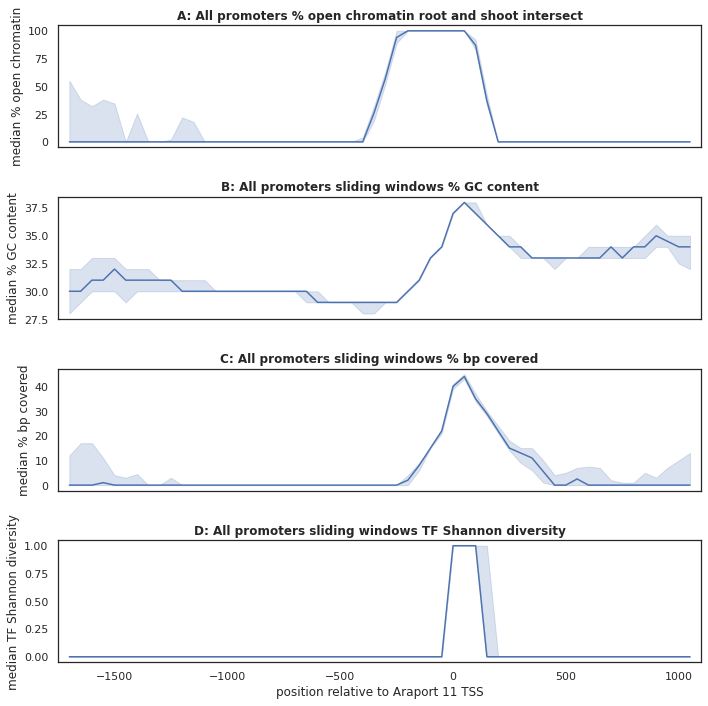

In [23]:
#all promoters in genome - median
all_proms = windows_coords('EPD_allproms',all_combined,'percentage_GC_content','% GC content',
                           'percentage_bases_covered','% bp covered',
                           'Shannon_diversity_TF','TF Shannon diversity',
                           promoter_bed,promoter_5UTR_bed,50,estimator='median')

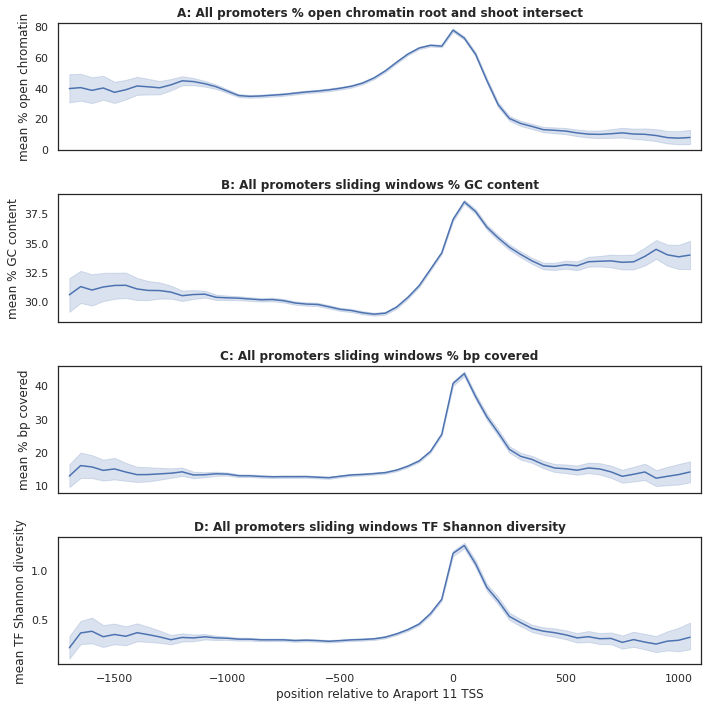

In [24]:
#all promoters in genome - mean
all_proms = windows_coords('EPD_allproms',all_combined,'percentage_GC_content','% GC content',
                           'percentage_bases_covered','% bp covered',
                           'Shannon_diversity_TF','TF Shannon diversity',
                           promoter_bed,promoter_5UTR_bed,50,estimator='mean')

## Now do constitutive and variable promoter from Czechowski et al 2005

In [25]:
#add gene type column to all_combined df
all_combined_genetype = add_genetype(all_combined, Czechowski_gene_categories)

sample size in each category = 90


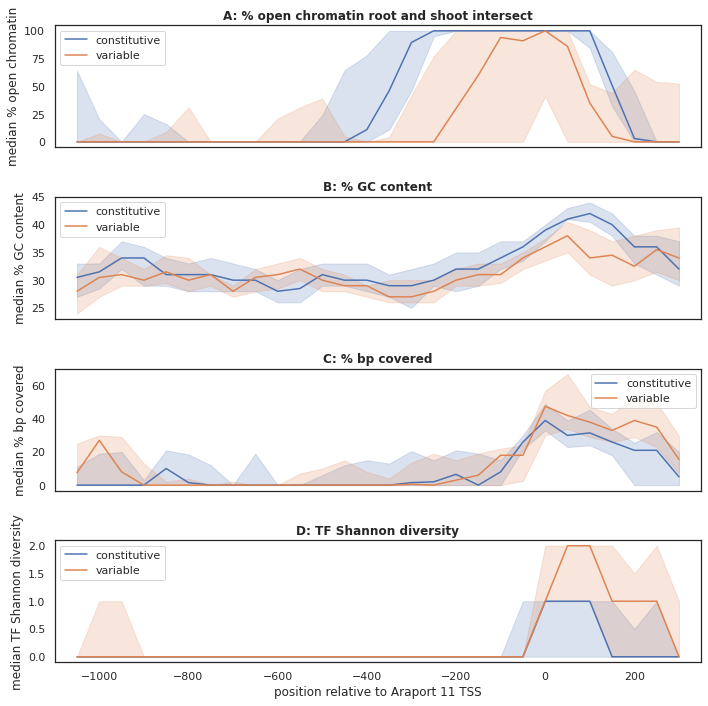

In [26]:
#plot median
rolling_rootshootintersect = windows_coords('EPD_Czechowski_genetypenocontrol',all_combined_genetype,
                                            'percentage_GC_content','% GC content',
                                            'percentage_bases_covered','% bp covered',
                                            'Shannon_diversity_TF','TF Shannon diversity',
                                            promoter_bed,promoter_5UTR_bed,
                                            50,estimator='median',
                                            genetype='constitutive', genetype2='variable',
                                            ci=95, n_boot=10000)

sample size in each category = 90


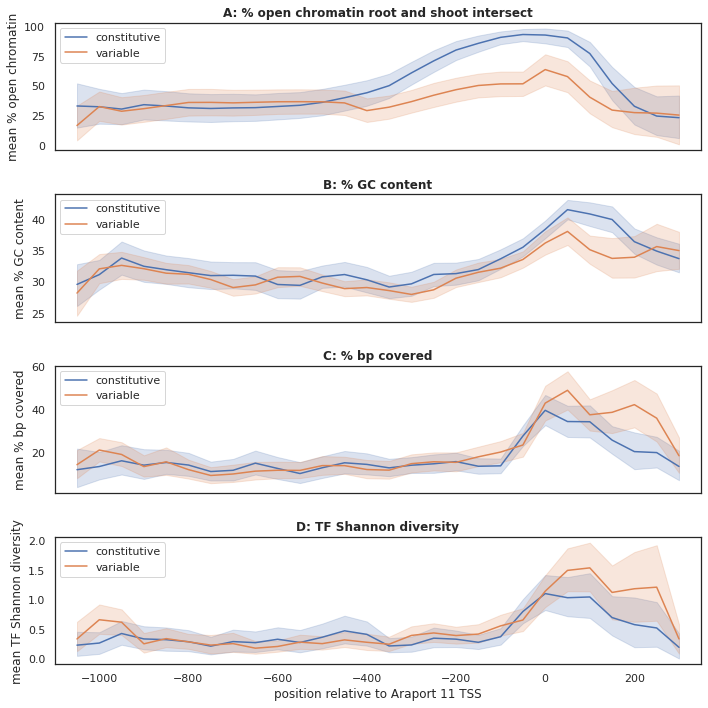

In [27]:
#plot mean
rolling_rootshootintersect = windows_coords('EPD_Czechowski_genetypenocontrol',all_combined_genetype,
                                            'percentage_GC_content','% GC content',
                                            'percentage_bases_covered','% bp covered',
                                            'Shannon_diversity_TF','TF Shannon diversity',
                                            promoter_bed,promoter_5UTR_bed,
                                            50,estimator='mean',
                                            genetype='constitutive', genetype2='variable',
                                            ci=95, n_boot=10000)

sample size in each category = 90


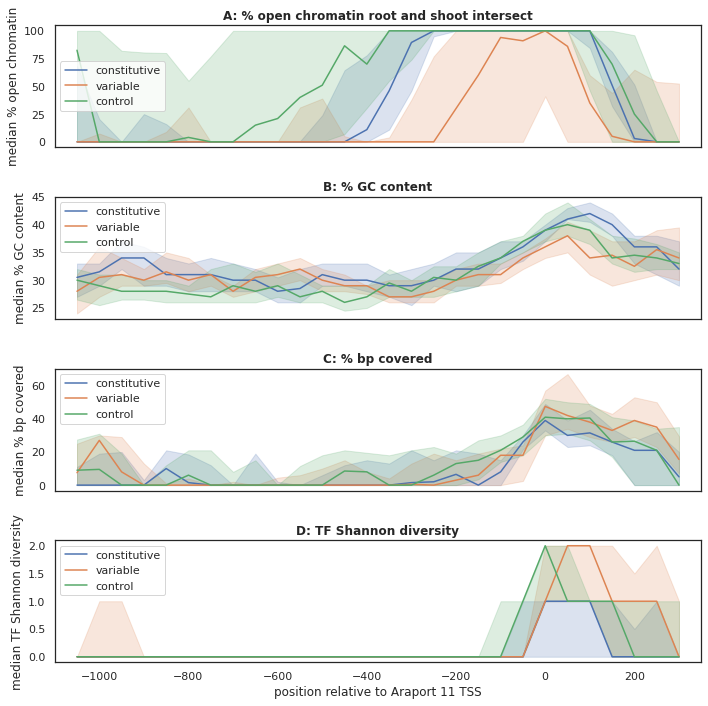

In [28]:
#plot with control genetype too
rolling_incl_control = windows_coords('EPD_Czechowski_genetype',all_combined_genetype,
                                      'percentage_GC_content','% GC content',
                                      'percentage_bases_covered','% bp covered',
                                      'Shannon_diversity_TF','TF Shannon diversity',
                                      promoter_bed,promoter_5UTR_bed,
                                      50,estimator='median',
                                      genetype='constitutive', genetype2='variable', genetype3='control',
                                      ci=95, n_boot=10000)

## plot lengths

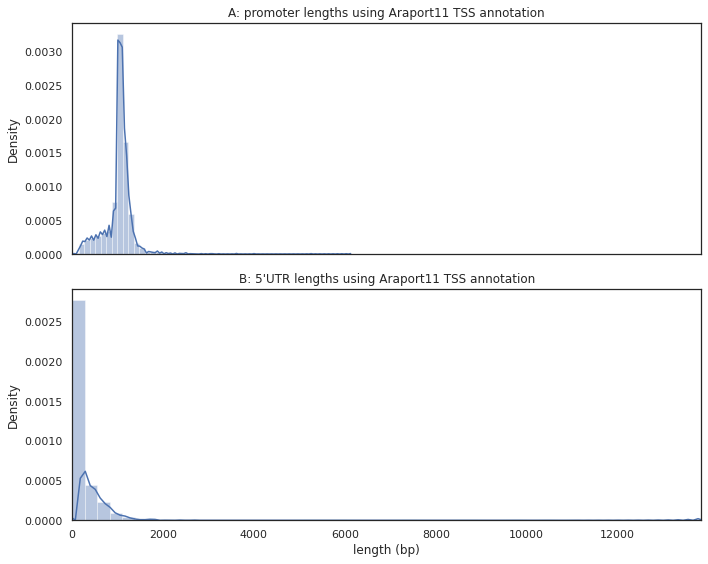

In [29]:
# plot promoter and 5'UTR length distribution
plot_length(all_proms,'EPD_allproms')

In [30]:
#add genetype column
all_combined_types_length = add_genetype(all_proms, Czechowski_gene_categories)

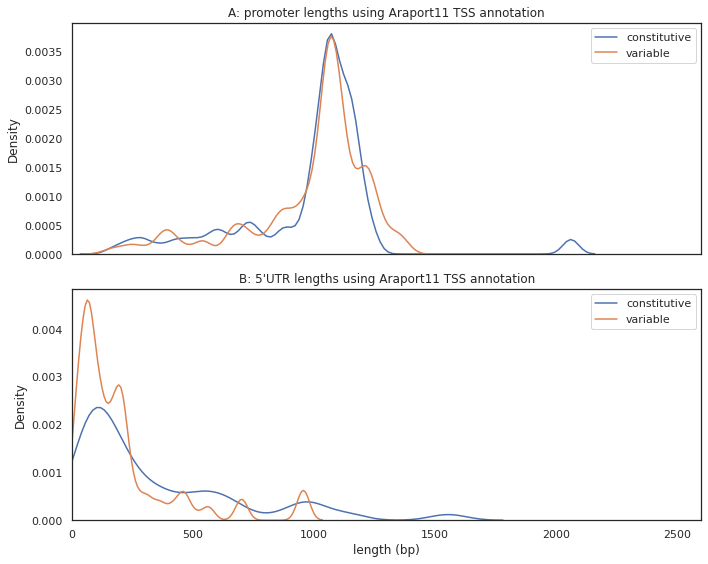

In [31]:
# plot promoter and 5'UTR length distribution for each genetype excluding control genes
plot_length(all_combined_types_length,'EPD_Czechowski_genetypenocontrol', genetype='constitutive', genetype2='variable')

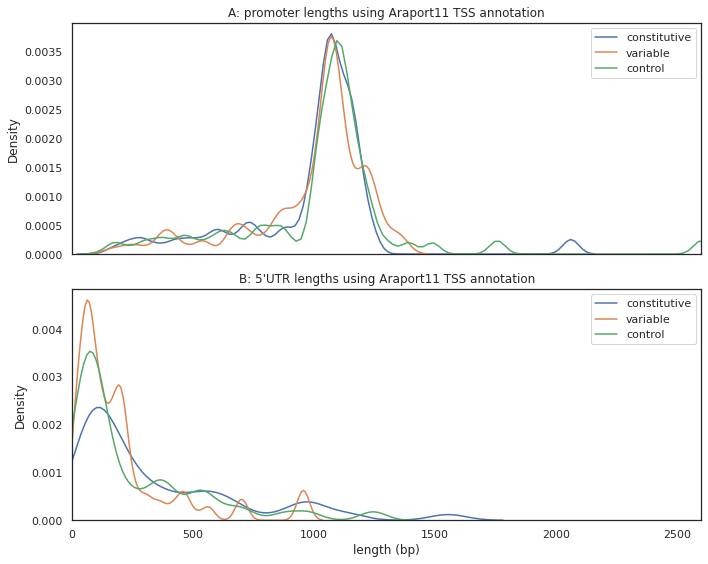

In [32]:
# plot promoter and 5'UTR length distribution for each genetype including control genes
plot_length(all_combined_types_length,'EPD_Czechowski_genetype', genetype='constitutive', genetype2='variable', genetype3='control')